In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

/Users/hoperuse/Projects/htc-analysis/new_env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Loading OCPF data under all filing IDs
ocpf_10176 = pd.read_csv('ocpf-output-10176.csv') # ocpf filings under filer 10176 Galvin, William F.

ocpf_20176 = pd.read_csv('ocpf-output-20176.csv') # ocpf filings under filer 20176 Galvin, William F.

ocpf_30176 = pd.read_csv('ocpf-output-30176.csv') # ocpf filings under filer 30176 Galvin, William F.

total_ocpf = pd.concat([ocpf_10176, ocpf_20176,ocpf_30176], ignore_index=True) # concatenating to one dataframe

In [3]:
# cleaning contributor column
total_ocpf.Contributor=total_ocpf.Contributor.astype(str).apply(lambda x: x.replace('\n',""))
total_ocpf.Contributor = total_ocpf.Contributor.astype(str).apply(lambda x: x.replace(', Sr.', ' Sr.'))
total_ocpf.Contributor = total_ocpf.Contributor.astype(str).apply(lambda x: x.replace(', Jr.', ' Jr.'))

# cleaning Zip column
total_ocpf['Zip'] = total_ocpf.Zip.astype(str)
total_ocpf.Zip = total_ocpf.Zip.apply(lambda x: x.replace('.0',''))
total_ocpf.loc[(total_ocpf.Zip.str.len() == 4) & ((total_ocpf['State'] == 'MA') | (total_ocpf['State'] == 'RI') | (total_ocpf['State'] == 'CT') | (total_ocpf['State'] == 'ME') | (total_ocpf['State'] == 'NH') | (total_ocpf['State'] == 'NJ')), 'Zip'] = "0" + total_ocpf.Zip

# turning date col into datetime objects, creating separate year column
total_ocpf['Date'] = pd.to_datetime(total_ocpf.Date)
total_ocpf['Year'] = total_ocpf['Date'].dt.year

# matching case to city shapefile
total_ocpf.City = total_ocpf.City.str.upper()

In [4]:
# splitting contributor column into first, last,middle, and suffix
total_ocpf_individual = total_ocpf.loc[total_ocpf['Record Type Description'] == 'Individual']
total_ocpf[['Contributor_last','Contributor_first']] = total_ocpf.loc[total_ocpf['Record Type Description'] == 'Individual'].Contributor.str.rsplit(',',1, expand=True)
total_ocpf

# Reordering columns
total_ocpf = total_ocpf[['Date', 'Contributor', 'Contributor_first','Contributor_last',
        'Address', 'City', 'State', 'Zip', 'Occupation',
       'Employer', 'Principal Officer', 'Amount', 'CPF ID', 'Recipient',
       'Tender Type ID', 'Tender Type Description', 'Record Type ID',
       'Record Type Description', 'Source Description', 'Year']]
       
# total_ocpf

In [5]:
total_ocpf['Amount'] = total_ocpf.Amount.str.replace('$','')
total_ocpf['Amount'] = total_ocpf.Amount.str.replace(',','')
total_ocpf['Amount'] = pd.to_numeric(total_ocpf['Amount'])

/var/folders/28/4n2m2j3n3_3gt31qw5m99kkc0000gn/T/ipykernel_15244/2016307980.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  total_ocpf['Amount'] = total_ocpf.Amount.str.replace('$','')


In [6]:
tax_credits = pd.read_csv('round_53_17_latest_round.csv')
tax_credits = tax_credits.rename(columns={'Name of Property': 'property_name',
                            'Prior Rounds Applications': 'prior_rounds_applications',
                            'Proponent Name': 'proponent_name',
                            'Remaining Credit to Award': 'remaining_credit_to_award',
                            'Total Awards': 'total_awards',
                            'Part 2 Qualified Rehab. $':'part_2_qualified_rehab_$',
                            'Part 2 Total Project Cost': 'part_2_total_project_cost'})

# formatting name to match names in OCPF records 
# tax_credits.proponent_name = tax_credits.proponent_name.apply(lambda x: x.split(' ')[-1] + ', '+ ' '.join(x.split(' ')[:-1]))
tax_credits[['Contributor_first','Contributor_last']] = tax_credits['proponent_name'].str.rsplit(' ', 1, expand=True)
tax_credits[['Contributor_first','Contributor_middle']] = tax_credits.Contributor_first.str.split(' ', 1, expand=True)
tax_credits.loc[tax_credits['City/Town'].str.contains('Boston') == True,'City/Town'] = 'Boston'
tax_credits.loc[tax_credits['City/Town'].str.contains('Bosotn')==True,'City/Town'] = 'Boston'
tax_credits.Entity = tax_credits.Entity.str.replace("Prtnrsp.", "Partnership")

/var/folders/28/4n2m2j3n3_3gt31qw5m99kkc0000gn/T/ipykernel_15244/3371246359.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  tax_credits.Entity = tax_credits.Entity.str.replace("Prtnrsp.", "Partnership")


In [7]:
# tax_credits.Entity = tax_credits.Entity.str.replace("WinnDevelopment", "Winn Development")
tax_credits['entities_list'] = ""
total_ocpf["Company_Bucket"] = ""

In [8]:
arthur_gilbert = (total_ocpf.Contributor_first == "Arthur M.") | (total_ocpf.Contributor_first == "Gilbert J.")
winn_last = total_ocpf.Contributor_last == "Winn"
winn_employer = total_ocpf.Employer.str.contains("Winn") == True
winn_board_addresses = (total_ocpf.Address == "29 Beach Street") | (total_ocpf.Address.str.contains("105 Duane St") == True) | (total_ocpf.Address == '6 Faneuil Hall Marketplace') | (total_ocpf.Address.str.contains("211 Ipswich"))
winn_filter = (winn_last & arthur_gilbert) | winn_employer | winn_board_addresses
winn = total_ocpf.loc[winn_filter]
total_ocpf.loc[winn_filter,'Company_Bucket'] = "WinnCompanies"

In [9]:
winn_htc = tax_credits.loc[tax_credits.Entity.str.contains("Winn") == True]
print(f'Winn Companies:\nTotal Credits Awarded: {len(winn_htc.index)}\nTotal Amount Awarded: {sum(winn_htc.total_awards)}\nTotal Number of Donations: {len(winn.index)}\nTotal Donation Amount: {sum(winn.Amount)}')

Winn Companies:
Total Credits Awarded: 6
Total Amount Awarded: 22453000
Total Number of Donations: 32
Total Donation Amount: 18500.0


In [10]:
# --- WinnCompanies President, Lawrence H. Curtis ---
lawrence_h_curtis_htc = tax_credits.loc[(tax_credits.proponent_name.str.contains("Lawrence") == True) & (tax_credits.proponent_name.str.contains("Curtis") == True)]
lawrence_h_curtis_ocpf = total_ocpf.loc[((total_ocpf.Contributor_first.str.contains("Lawrence") == True) & (total_ocpf.Contributor_last.str.contains("Curtis") == True)) | (total_ocpf.Address.str.contains("211 Ipswich Road"))]
print(f"Lawrence H. Curtis, President, WinnCompanies\nTotal Donations Given: {len(lawrence_h_curtis_ocpf.index)}\nTotal Amount Given: {sum(lawrence_h_curtis_ocpf.Amount)}\nTotal Credits Awarded: {len(lawrence_h_curtis_htc.index)}\nTotal Amount Awarded: {sum(lawrence_h_curtis_htc.total_awards)}\nNumber of Entities Listed: {len(list(lawrence_h_curtis_htc.Entity.unique()))}\nUnique Entities: {list(lawrence_h_curtis_htc.Entity.unique())}")

Lawrence H. Curtis, President, WinnCompanies
Total Donations Given: 9
Total Amount Given: 5500.0
Total Credits Awarded: 17
Total Amount Awarded: 28203000
Number of Entities Listed: 9
Unique Entities: ['Fitchburg Yarn Limited Partnership', 'Ludlow Mill Housing Limited Partnership', 'Voke Lofts Limited Partnership by Voke Winn Lofts LLC', 'MM Lawrence II Limited Partnership', 'Baker Square II Limited Partnership  c/oWinnDevelopment', 'Pickle-Ditson Ltd. Partnership c/o WinnDevelopment', 'Canal Lofts Limited Partnership c/o WinnDevelopment', 'WinnDevelopment or Its Nominee', 'Wellington Redevelopment 2 GPLLC']


In [11]:
# --- CRUZ COMPANIES ---
cruz_filter = (total_ocpf.Employer == "Cruz Construction") | (total_ocpf.Employer == "Cruz Development Corp.")| (total_ocpf.Employer == "Cruz Real Estate") | (total_ocpf.Address == "56 Eliot Street") | (total_ocpf.Address == "48 Cedar Street") | (total_ocpf.Address == "12 Schuyler Street") | (total_ocpf.Contributor == 'Whiting, Deborah L.')
cruz = total_ocpf.loc[cruz_filter]
total_ocpf.loc[cruz_filter, "Company_Bucket"] = "Cruz Companies"

cruz_htc = tax_credits.loc[(tax_credits.proponent_name.str.contains('John B Cruz') == True) | (tax_credits.proponent_name.str.contains('Daniel Cruz, Jr') == True) | (tax_credits.Entity.str.contains('Wayne at Bicknell, LLC') == True) | (tax_credits.Entity.str.contains('Cruz Development') == True) | (tax_credits.Entity.str.contains('WBH Housing LLC') == True)]
print(f'Cruz Companies:\nTotal Credits Awarded: {len(cruz_htc.index)}\nTotal Amount Awarded: {sum(cruz_htc.total_awards)}\nTotal Number of Donations: {len(cruz.index)}\nTotal Donation Amount: {sum(cruz.Amount)}')

Cruz Companies:
Total Credits Awarded: 9
Total Amount Awarded: 4700000
Total Number of Donations: 47
Total Donation Amount: 21225.0


In [12]:
# --- TRINITY FINANCIAL GROUP ---
trinity_financial_filter = total_ocpf.Employer.str.contains("Trinity Financial") == True
trinity_financial_htc = tax_credits.loc[(tax_credits.Entity.str.contains('Trinity') == True) & (tax_credits.proponent_name.str.contains('Keefe') == True)]
trinity_financial_ocpf = total_ocpf.loc[trinity_financial_filter]
total_ocpf.loc[trinity_financial_filter, 'Company_Bucket'] = "Trinity Financial"
print(f'Trinity Financial Group:\nTotal Credits Awarded: {len(trinity_financial_htc.index)}\nTotal Amount Awarded: {sum(trinity_financial_htc.total_awards)}\nTotal Number of Donations: {len(trinity_financial_ocpf.index)}\nTotal Donation Amount: {sum(trinity_financial_ocpf.Amount)}')

Trinity Financial Group:
Total Credits Awarded: 4
Total Amount Awarded: 5900000
Total Number of Donations: 41
Total Donation Amount: 17800.0


In [13]:
# --- KAVANAGH ADVISORY GROUP --- 
kavanagh_filter = (total_ocpf.Contributor.str.contains("Tinti")==True) | (total_ocpf.Address.str.contains("99 Conifer Hill Dr") == True) | (total_ocpf.Contributor.str.contains("Gervais")==True)
kavanagh_advisory = total_ocpf.loc[kavanagh_filter]
total_ocpf.loc[kavanagh_filter,'Company_Bucket'] = "Kavanagh Advisory Group"

kavanagh_htc = tax_credits.loc[tax_credits.Entity.str.contains("Kavanagh") == True]
print(f'Kavanagh Group:\nTotal Credits Awarded: {len(kavanagh_htc.index)}\nTotal Amount Awarded: {sum(kavanagh_htc.total_awards)}\nTotal Number of Donations: {len(kavanagh_advisory.index)}\nTotal Donation Amount: {sum(kavanagh_advisory.Amount)}')

Kavanagh Group:
Total Credits Awarded: 0
Total Amount Awarded: 0
Total Number of Donations: 4
Total Donation Amount: 2350.0


In [14]:
# --- WINGATE COMPANIES ---
wingate_filter = (total_ocpf.Address.str.contains("100 Wells Avenue")) | (total_ocpf.Employer.str.contains("Wingate") == True)
wingate = total_ocpf[wingate_filter]
total_ocpf.loc[wingate_filter,'Company_Bucket'] = "Wingate Companies"
wingate_htc = tax_credits.loc[tax_credits.Entity.str.contains('Wingate') == True]
print(f'Wingate Companies:\nTotal Credits Awarded: {len(wingate_htc.index)}\nTotal Amount Awarded: {sum(wingate_htc.total_awards)}\nTotal Number of Donations: {len(wingate.index)}\nTotal Donation Amount: {sum(wingate.Amount)}')

Wingate Companies:
Total Credits Awarded: 0
Total Amount Awarded: 0
Total Number of Donations: 112
Total Donation Amount: 68615.0


In [15]:
first_resource_htc = tax_credits.loc[tax_credits.proponent_name.str.contains('Pulsifer') == True]
first_resource_ocpf = total_ocpf.loc[(total_ocpf.Contributor.str.contains('Pulsifer')) | (total_ocpf.Employer.str.contains("First Resource Companies"))]
print(f'First Resource Companies / Gordon Pulsifer:\nTotal Credits Awarded: {len(first_resource_htc.index)}\nTotal Amount Awarded: {sum(first_resource_htc.total_awards)}\nTotal Number of Donations: {len(first_resource_ocpf.index)}\nTotal Donation Amount: {sum(first_resource_ocpf.Amount)}\nNumber of Entities Listed: {len(list(first_resource_htc.Entity.unique()))}\nUnique Entities: {list(first_resource_htc.Entity.unique())}')

First Resource Companies / Gordon Pulsifer:
Total Credits Awarded: 41
Total Amount Awarded: 18850000
Total Number of Donations: 4
Total Donation Amount: 4000.0
Number of Entities Listed: 11
Unique Entities: ['Outing Park Apartments I Limited Partnership, Outing Park Apartments I LLC its General Partner, First Resource Development Company', 'Outing Park Apartments II Limited Partnership, Outing Park Apartments II LLC, its General Partner, First Resource Development Company', 'Concord Heights Limited Partnership, Concord Heights LLC, Its General Partner, First Resource Development Company', 'Maple Green Limited Partnership (Maple Green LLC its General Partner)', 'Maple Green Limited Partnership (MapleGreen LLC its General Partner)', 'Concord Heights LimitedPartnership, Concord Heights LLC, Its General Partner, First Resource DevelopmentCompany', 'City View Commons Limited Partnership II, City View Commons II LLC, Its General Partner', 'City View Commons LimitedPartnership  c/o First Reso

In [16]:
picknelly_htc = tax_credits.loc[tax_credits.proponent_name.str.contains('Picknelly') == True]
picknelly_ocpf = total_ocpf.loc[(total_ocpf.Contributor.str.contains('Picknelly') == True) | (total_ocpf.Address.str.contains("330 Park Drive") == True)]
print(f'OPAL Real Estate / Peter Picknelly / Peter Pan Buses:\nTotal Credits Awarded: {len(picknelly_htc.index)}\nTotal Amount Awarded: {sum(picknelly_htc.total_awards)}\nTotal Number of Donations: {len(picknelly_ocpf.index)}\nTotal Donation Amount: {sum(picknelly_ocpf.Amount)}\nNumber of Entities Listed: {len(list(picknelly_htc.Entity.unique()))}\nUnique Entities: {list(picknelly_htc.Entity.unique())}')
# picknelly_htc

OPAL Real Estate / Peter Picknelly / Peter Pan Buses:
Total Credits Awarded: 8
Total Amount Awarded: 6950000
Total Number of Donations: 10
Total Donation Amount: 4900.0
Number of Entities Listed: 2
Unique Entities: ['Historic Round Hill Summit, LLC c/o OPAL Real Estate Group', 'University Housing LLC']


In [17]:
olde_town_realty_htc = tax_credits.loc[(tax_credits.Entity.str.contains("Olde Town Team Realty") == True) | (tax_credits.Entity.str.contains("NESVI") == True)]
hcl_acquisition_heritage_foundation_htc = tax_credits.loc[(tax_credits.Entity.str.contains('Architectural Heritage Foundation') == True) | (tax_credits.proponent_name.str.contains('Sean McDonnell') == True) | (tax_credits.Entity.str.contains('HCL Acquisition LLC') == True)]
abbott_mill_htc = tax_credits.loc[tax_credits.Entity.str.contains("Abbott Mill") == True]
winnDevelopment = tax_credits.loc[(tax_credits.Entity.str.contains("WinnDevelopment") == True) | (tax_credits.Entity.str.contains("Winn Development") == True)]
suffolk_medford = tax_credits.loc[(tax_credits.Entity.str.contains('Suffolk Medford') == True) | (tax_credits.Entity.str.contains('SuffolkMedford') == True) | (tax_credits.Entity.str.contains('Suffolk medford') == True) | (tax_credits.Entity.str.contains('suffolk Medford') == True) | (tax_credits.proponent_name.str.contains('Rauseo') == True)]
htc_160_water = tax_credits.loc[(tax_credits.Entity.str.contains("160 Water") == True) | (tax_credits.Entity.str.contains("Bart Mitchell") == True)]
historic_round_hill_summit_htc = tax_credits.loc[(tax_credits.Entity.str.contains("Historic Round Hill Summit") == True) | (tax_credits.proponent_name.str.contains("Picknelly") == True) | (tax_credits.Entity.str.contains("OPAL Real Estate Group") == True) | (tax_credits.Entity.str.contains("University Housing LLC") == True)]
bc_shovel_works_htc = tax_credits.loc[(tax_credits.Entity.str.contains("BC Shovel Works") == True) | (tax_credits.proponent_name.str.contains("Pamela Goodman") == True) | (tax_credits.Entity.str.contains("Beacon Communities") == True)]
bc_shovel_works_htc 

,Unnamed: 0,City/Town,property_name,Use**,prior_rounds_applications,proponent_name,remaining_credit_to_award,total_awards,20% QRE,Qualified Rehab. $,Total Project Cost,HRC #,Entity,part_2_qualified_rehab_$,part_2_total_project_cost,Count_prior_rounds_applied,Contributor_first,Contributor_last,Contributor_middle,entities_list
100,790,Easton,"Oliver Ames & Sons Shovel Works, 26, 28 & 34 M...",R,"20, 21, 22, 23,24, 25, 26",Pamela Goodman,2207299.0,6100000,6307299.0,31536495.0,47613289.0,258.0,BC Shovel Works LLC c/o Beacon Communities,NaN,NaN,7.0,Pamela,Goodman,None,


In [18]:
kessler_ocpf = total_ocpf.loc[(total_ocpf.Employer.str.contains("Kessler") == True) | (total_ocpf.Address.str.contains("120 Casa Bendita") == True)]
print(f'Kessler Group:\nTotal Number of Donations: {len(kessler_ocpf.index)}\nTotal Amount: {sum(kessler_ocpf.Amount)}')

Kessler Group:
Total Number of Donations: 30
Total Amount: 25450.0


In [19]:
# --- CABOT, CABOT, AND FORBES ---
cabot_board = [["Jay","Doherty"],
    ["John","Doherty"],
    ["John","Sullivan"],
    ["Daniel B.","Nagler"],
    ["Allie", "Sullivan"],
    ["Jacob","Vance"],
    ["Mike", "Modoono"],
    ["Matt","D'Amico"],
    ["Shaun","Sullivan"],
    ["Hayley","Glidden"]]

cabot_filter = (total_ocpf.Employer.str.contains("Cabot") == True) | (total_ocpf.Address == "12 Tappan Road")| (total_ocpf.Address == "19 Daniels Road")
cabot_forbes_ocpf = total_ocpf.loc[cabot_filter]
total_ocpf.loc[cabot_filter,'Company_Bucket'] = "Cabot"
cabot_forbes_htc = tax_credits.loc[(tax_credits.Entity.str.contains("Cabot") == True)]
# print(f'Trinity Financial Group:\nTotal Credits Awarded: {len(trinity_financial_htc.index)}\nTotal Amount Awarded: {sum(trinity_financial_htc.total_awards)}\nTotal Number of Donations: {len(trinity_financial_ocpf.index)}\nTotal Donation Amount: {sum(trinity_financial_ocpf.Amount)}')
cabot_forbes_htc

,Unnamed: 0,City/Town,property_name,Use**,prior_rounds_applications,proponent_name,remaining_credit_to_award,total_awards,20% QRE,Qualified Rehab. $,Total Project Cost,HRC #,Entity,part_2_qualified_rehab_$,part_2_total_project_cost,Count_prior_rounds_applied,Contributor_first,Contributor_last,Contributor_middle,entities_list


In [20]:
# --- UNITED GROUP ---
# include united liquors because at index 18, united liquors donated 500 from the same address as United Group
united_group_ocpf = total_ocpf.loc[(total_ocpf.Employer.str.contains("The United Group")== True) | (total_ocpf.Employer.str.contains("United Group") == True) | (total_ocpf.Employer.str.contains("United Liquors")== True) | (total_ocpf.Address.str.contains("1 United") == True) | (total_ocpf.Address.str.contains("175 Campanelli") == True)]
united_group_htc = tax_credits.loc[(tax_credits.Entity.str.contains("United Group") == True) | (tax_credits.proponent_name.str.contains("Tye") == True)]
united_group_htc

,Unnamed: 0,City/Town,property_name,Use**,prior_rounds_applications,proponent_name,remaining_credit_to_award,total_awards,20% QRE,Qualified Rehab. $,Total Project Cost,HRC #,Entity,part_2_qualified_rehab_$,part_2_total_project_cost,Count_prior_rounds_applied,Contributor_first,Contributor_last,Contributor_middle,entities_list


In [21]:
total_ocpf.loc[total_ocpf.Employer.str.contains("Winn") == True]['Amount'].sum()
total_ocpf.groupby(by="Address").count().query("Contributor > 1")

,Date,Contributor,Contributor_first,Contributor_last,City,State,Zip,Occupation,Employer,Principal Officer,Amount,CPF ID,Recipient,Tender Type ID,Tender Type Description,Record Type ID,Record Type Description,Source Description,Year,Company_Bucket
Address,,,,,,,,,,,,,,,,,,,,
"1 Avery Street, Apt 25 B",4,4,4,4,4,4,4,4,4,0,4,4,4,4,4,4,4,4,4,4
1 Balsam Circle,3,3,3,3,3,3,3,3,3,0,3,3,3,3,3,3,3,3,3,3
1 Bushnell Drive,6,6,6,6,6,6,6,6,6,0,6,6,6,6,6,6,6,6,6,6
"1 Charles Street S., #1105",2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2
1 Colonial Lane,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Three Center Plaza,5,5,5,5,5,5,5,5,5,0,5,5,5,5,5,5,5,5,5,5
"Three Center Plaza, Floor 8",7,7,7,7,7,7,7,7,7,0,7,7,7,7,7,7,7,7,7,7
Two Center Plaza Suite 4M,5,5,0,0,5,5,5,0,0,0,5,5,5,5,5,5,5,5,5,5


In [22]:
the_homemakers_filter = (total_ocpf.Employer.str.contains("Homemaker") == True) | (total_ocpf.Occupation.str.contains("Homemaker") == True) | (total_ocpf.Occupation.str.contains("At Home") == True)
the_homemakers = total_ocpf.loc[the_homemakers_filter]
partner_addresses = list(set(the_homemakers.Address.values))

check = total_ocpf.loc[(total_ocpf.Address.isin(partner_addresses))]
# check.loc[(check.Occupation.str.contains("Homemaker")==False) & (check.Occupation.str.contains("At Home")==False) & (check.Occupation.str.contains("At home")==False)]
set(check.loc[(check.Occupation.str.contains("President") == True),'Employer'].values)

{'Commonwealth Ventures',
 'Continental Wingate',
 'Cruz Construction',
 'Gerald: Continental Wingate',
 'Global Companies Llc',
 'Global Partners',
 'Global Petroleum',
 'Global Petroleum Corp.',
 'Hadco Window & Door Mfg. Co., Inc.',
 'Harry Miller Co., Inc.',
 'Harry Miller Company',
 'Interface Group',
 'Leisman Insurance Agency, Inc.',
 'Maric, Inc.',
 'Mutual Oil Co., Inc., Brockton, MA',
 'Retro Fit Tech.',
 'Retrofit, Inc.',
 'The Interface Group',
 'The United Group'}

In [23]:
total_ocpf.loc[(total_ocpf.Employer != "Nixon Peabody") & (total_ocpf.Employer != "Proceeds From Matured Cd.") & (total_ocpf.Employer != "Self") & (total_ocpf.Employer != "Retired") & (total_ocpf.Employer != "At Home") & (total_ocpf.Employer != "Self-employed") & (total_ocpf.Employer != "Self-Employed")& (total_ocpf.Employer != "Information Requested")].groupby("Employer").sum().sort_values(by="Amount",ascending=False).head(20)

,Amount,CPF ID,Tender Type ID,Record Type ID,Year
Employer,,,,,
Arbella,17700.0,447744,44,8844,88550
Wingate Healthcare,16000.0,356160,37,7035,70452
Cruz Construction,13850.0,264576,26,5226,52381
Trinity Financial,13300.0,356160,35,7035,70703
Wingate Companies,13250.0,172992,23,3417,34321
Continental Wingate,13240.0,193344,18,4019,38232
Interface Group,13000.0,142464,14,2814,28241
Sloane & Walsh,12850.0,295104,29,5829,58368
Homemaker,12250.0,254400,27,5025,50344


In [24]:
t1 = total_ocpf.groupby(by='Contributor_last').count()
t2 = tax_credits.groupby(by='Contributor_last').count()
t1.merge(t2, on="Contributor_last").index

Index(['Ansin', 'Barry', 'Becker', 'Bell', 'Benjamin', 'Brown', 'Carver',
       'Cohen', 'Collins', 'Cooper', 'Curran', 'Curtis', 'Delaney', 'Dennis',
       'Dowd', 'Downing', 'Epker', 'Ewing', 'Ferguson', 'Fish', 'Flores',
       'Frias', 'Friedman', 'Gagliardi', 'Galvin', 'Gately', 'Gillespie',
       'Goldman', 'Goodman', 'Greene', 'Harris', 'Harrison', 'Hoff', 'Keefe',
       'Long', 'Mackey', 'Macomber', 'McCarthy', 'McDonnell', 'McGrail',
       'McGrath', 'Miller', 'Mitchell', 'Mittelstadt', 'Monahan', 'O'Neil',
       'Oftring', 'Park', 'Pearson', 'Peterson', 'Picknelly', 'Price',
       'Pulsifer', 'Relich', 'Robbins', 'Rudzinski', 'Russo', 'Shea', 'Smith',
       'Snider', 'Starr', 'Stein', 'Stewart', 'Stone', 'Stratouly', 'Sullivan',
       'Thompson', 'Thornton', 'Tierney', 'Timilty', 'Toomey', 'Waite',
       'Walsh', 'Ward', 'Wells', 'White', 'Winn', 'Zimmerman'],
      dtype='object', name='Contributor_last')

In [25]:
total_ocpf.groupby(by='Contributor_last').count()

,Date,Contributor,Contributor_first,Address,City,State,Zip,Occupation,Employer,Principal Officer,Amount,CPF ID,Recipient,Tender Type ID,Tender Type Description,Record Type ID,Record Type Description,Source Description,Year,Company_Bucket
Contributor_last,,,,,,,,,,,,,,,,,,,,
ABCC Investigators Assn.,1,1,0,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1
Abare,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1
Abber,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1
Abbott,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1
Abdallah,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimmerman,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
Zink,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
Zinner,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1


In [26]:
tax_credits.loc[tax_credits.Contributor_last.str.contains('Lupoli')]

,Unnamed: 0,City/Town,property_name,Use**,prior_rounds_applications,proponent_name,remaining_credit_to_award,total_awards,20% QRE,Qualified Rehab. $,Total Project Cost,HRC #,Entity,part_2_qualified_rehab_$,part_2_total_project_cost,Count_prior_rounds_applied,Contributor_first,Contributor_last,Contributor_middle,entities_list
0,2431,Lawrence,Wood Worsted Mill Building C (formerly Office ...,R,"13 4, 15, 16,17, 18, 19, 20,21, 22, 23, 24,...",Salvatore Lupoli,574607.6,3000000,3574607.6,17873038.0,22481348.0,117.0,200 Riverwalk LLC,NaN,NaN,21.0,Salvatore,Lupoli,None,
10,2316,Lawrence,"Wood Worsted Mill Building F, 280 Merrimack St...",C,"27, 28, 29, 30,31, 32, 33, 34,35, 36, 37, 38,3...",Salvatore Lupoli,5493282.0,5000000,10493282.0,52466410.0,63324227.0,412.0,280 Riverwalk LLC,NaN,NaN,15.0,Salvatore,Lupoli,None,


In [27]:
total_credits = tax_credits.total_awards.sum()
num_credits = len(tax_credits.index)
print(f'Total Number of Credits Awarded: {num_credits}\nTotal Amount in Credits Awarded: {total_credits}')

Total Number of Credits Awarded: 468
Total Amount in Credits Awarded: 443021816


In [28]:
towns = gpd.read_file('townssurvey_shp/TOWNSSURVEY_POLY.shp')

In [29]:
tax_credits_cities = tax_credits.groupby(by='City/Town').sum().sort_values(by='total_awards',ascending=False)
tax_credits_cities = tax_credits_cities.reset_index().drop(columns='Unnamed: 0')
tax_credits_cities['City/Town'] = tax_credits_cities['City/Town'].str.upper()
tax_credits_cities = tax_credits_cities.rename(columns={'City/Town': 'TOWN'})

In [63]:
tax_credits_cities.sort_values(by='total_awards',ascending=False).head(10)
tax_credits_cities['pct_total'] = tax_credits_cities.total_awards/tax_credits_cities.total_awards.sum()*100
tax_credits_cities[['TOWN','total_awards','pct_total']].sort_values(by='total_awards',ascending=False).head(10).to_csv('test1.csv')


In [31]:
tax_credits_cities_geomerge = towns.merge(tax_credits_cities, on='TOWN', how='inner')
tax_credits_cities_geomerge

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH90_00,TYPE,ISLAND,COASTAL_PO,FOURCOLOR,...,geometry,remaining_credit_to_award,total_awards,20% QRE,Qualified Rehab. $,Total Project Cost,HRC #,part_2_qualified_rehab_$,part_2_total_project_cost,Count_prior_rounds_applied
0,FALMOUTH,96,25007,27960,32660,4700,T,1,NO,2,...,"POLYGON ((268360.782 808386.365, 268347.943 80...",123484.47,0,123484.47,617422.36,750000.0,216.0,0.0,0.0,0.0
1,FALMOUTH,96,25007,27960,32660,4700,T,1,NO,2,...,"POLYGON ((277887.593 814023.755, 277886.782 81...",123484.47,0,123484.47,617422.36,750000.0,216.0,0.0,0.0,0.0
2,FALMOUTH,96,25007,27960,32660,4700,T,1,NO,2,...,"POLYGON ((278562.032 811588.625, 278561.032 81...",123484.47,0,123484.47,617422.36,750000.0,216.0,0.0,0.0,0.0
3,FALMOUTH,96,25007,27960,32660,4700,T,0,NO,2,...,"POLYGON ((273213.373 823396.815, 273260.812 82...",123484.47,0,123484.47,617422.36,750000.0,216.0,0.0,0.0,0.0
4,FALMOUTH,96,25007,27960,32660,4700,T,1,NO,2,...,"POLYGON ((279774.472 814028.755, 279774.593 81...",123484.47,0,123484.47,617422.36,750000.0,216.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,FITCHBURG,97,39740,41194,39102,-2092,C,0,NO,4,...,"POLYGON ((177589.642 924379.135, 178248.062 92...",1828704.00,5700000,7528704.00,37643520.00,49601481.0,592.0,0.0,0.0,21.0
266,ADAMS,4,10181,9445,8809,-636,T,0,NO,3,...,"POLYGON ((71824.763 934966.135, 71785.163 9344...",164800.00,0,164800.00,824000.00,1029000.0,299.0,0.0,0.0,0.0
267,ORANGE,223,7054,7312,7518,206,T,0,NO,4,...,"POLYGON ((140544.523 932292.705, 140226.653 93...",326400.00,2100000,1826400.00,9132000.00,9947000.0,396.0,0.0,0.0,9.0
268,AGAWAM,5,26754,27323,28144,821,TC,0,NO,4,...,"POLYGON ((102185.312 873555.665, 102188.042 87...",409490.00,2200000,2609490.00,13047450.00,16294613.0,329.0,0.0,0.0,9.0


In [32]:
tax_credits_cities_geomerge.to_excel('city_sum_htc.xlsx')

<AxesSubplot:>

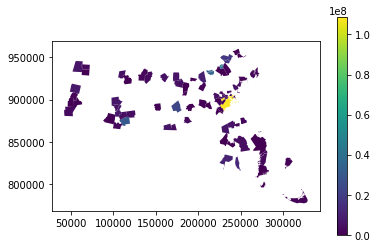

In [33]:
tax_credits_cities_geomerge.plot(column="total_awards",legend=True)

In [34]:
total_ocpf.loc[total_ocpf.Employer.str.contains("Congress") == True]

,Date,Contributor,Contributor_first,Contributor_last,Address,City,State,Zip,Occupation,Employer,...,Amount,CPF ID,Recipient,Tender Type ID,Tender Type Description,Record Type ID,Record Type Description,Source Description,Year,Company_Bucket
3755,2007-04-05,"Stratouly, Dean F.",Dean F.,Stratouly,2 Spruce St.,BOSTON,MA,02108,CEO,The Congress Group,...,500.0,10176,"Galvin, William F.",1,Check,201,Individual,4/5/07 Deposit Report,2007,
5379,2009-11-06,"Nicholson, William A.",William A.,Nicholson,2 Bourbon Street,PEABODY,MA,01960,Construction,Congress Construction,...,500.0,10176,"Galvin, William F.",1,Check,201,Individual,11/6/09 Deposit Report,2009,
7200,2013-04-12,"Stratouly, Dean F.",Dean F.,Stratouly,2 Spruce St.,BOSTON,MA,02108,CEO,The Congress Group,...,500.0,10176,"Galvin, William F.",1,Check,201,Individual,4/12/13 Deposit Report,2013,
7911,2014-10-10,"Stratouly, Dean F.",Dean F.,Stratouly,"409 Commonwealth Ave., Unit E",BOSTON,MA,02215,CEO,The Congress Group,...,250.0,10176,"Galvin, William F.",1,Check,201,Individual,10/10/14 Deposit Report,2014,
7914,2014-10-15,"Stratouly, Dean F.",Dean F.,Stratouly,"409 Commonwealth Ave., Unit E",BOSTON,MA,02215,CEO,The Congress Group,...,250.0,10176,"Galvin, William F.",1,Check,201,Individual,10/15/14 Deposit Report,2014,
8136,2015-09-14,"Stratouly, Dean F.",Dean F.,Stratouly,"409 Commonwealth Ave., Unit E",BOSTON,MA,02215,CEO,The Congress Group,...,500.0,10176,"Galvin, William F.",1,Check,201,Individual,9/14/15 Deposit Report,2015,
8521,2016-05-06,"Stratouly, Dean F.",Dean F.,Stratouly,"409 Commonwealth Ave., Unit E",BOSTON,MA,02215,CEO,The Congress Group,...,1000.0,10176,"Galvin, William F.",1,Check,201,Individual,5/6/16 Deposit Report,2016,
8939,2017-06-21,"Stratouly, Dean F.",Dean F.,Stratouly,"409 Commonwealth Ave., Unit E",BOSTON,MA,02215,CEO,The Congress Group,...,1000.0,10176,"Galvin, William F.",1,Check,201,Individual,6/21/17 Deposit Report,2017,
9495,2018-05-17,"Stratouly, Dean F.",Dean F.,Stratouly,124 Chestnut Street,BOSTON,MA,02108,Real Estate Developer,The Congress Group,...,1000.0,10176,"Galvin, William F.",1,Check,201,Individual,5/17/18 Deposit Report,2018,
10314,2019-07-08,"Stratouly, Dean",Dean,Stratouly,124 Chestnut Street,BOSTON,MA,02108,Real Estate,The Congress Group,...,1000.0,10176,"Galvin, William F.",1,Check,201,Individual,7/8/19 Deposit Report,2019,


In [35]:
total_ocpf.loc[total_ocpf.Contributor.str.contains('Tarbet') == True]

,Date,Contributor,Contributor_first,Contributor_last,Address,City,State,Zip,Occupation,Employer,...,Amount,CPF ID,Recipient,Tender Type ID,Tender Type Description,Record Type ID,Record Type Description,Source Description,Year,Company_Bucket


In [36]:
picknelly_htc = tax_credits.loc[(tax_credits.proponent_name.str.contains('Northcutt') == True)]
picknelly_ocpf = total_ocpf.loc[(total_ocpf.Contributor.str.contains('Cruz') == True)]
# print(f'First Resource Companies / Gordon Pulsifer:\nTotal Credits Awarded: {len(first_resource_htc.index)}\nTotal Amount Awarded: {sum(first_resource_htc.total_awards)}\nTotal Number of Donations: {len(first_resource_ocpf.index)}\nTotal Donation Amount: {sum(first_resource_ocpf.Amount)}\nNumber of Entities Listed: {len(list(first_resource_htc.Entity.unique()))}\nUnique Entities: {list(first_resource_htc.Entity.unique())}')
picknelly_htc

,Unnamed: 0,City/Town,property_name,Use**,prior_rounds_applications,proponent_name,remaining_credit_to_award,total_awards,20% QRE,Qualified Rehab. $,Total Project Cost,HRC #,Entity,part_2_qualified_rehab_$,part_2_total_project_cost,Count_prior_rounds_applied,Contributor_first,Contributor_last,Contributor_middle,entities_list
155,1838,Salem,"Congress and Dow Apartments, 52 - 60 Dow Street",R,"33, 34, 35, 36,37",Mickey Northcutt,579481.8,450000,1029481.8,5147409.0,7982801.0,594.0,Congress Street Residences LP,NaN,NaN,5.0,Mickey,Northcutt,None,
191,1754,Salem,"Congress and Dow Apartments, 105 - 109 Congres...",R,"33, 34, 35, 36",Mickey Northcutt,237193.4,225000,462193.4,2310967.0,3249536.0,592.0,"Congress & Dow, LLC",NaN,NaN,4.0,Mickey,Northcutt,None,
197,1755,Salem,"Congress and Dow Apartments, 111 Congress Street",R,"33, 34, 35, 36",Mickey Northcutt,200296.8,275000,475296.8,2376484.0,3500765.0,593.0,Congress & Dow LLC,NaN,NaN,4.0,Mickey,Northcutt,None,
262,1679,Salem,"Congress and Ward Apartments, 71 Palmer Street",R,"33, 34, 35",Mickey Northcutt,125094.8,225000,350094.8,1750474.0,2866848.0,596.0,"Congress & Ward, LLC",NaN,NaN,3.0,Mickey,Northcutt,None,
263,1680,Salem,"Congress and Ward Apartments, 32 Perkins Street",R,"33, 34, 35",Mickey Northcutt,132754.0,150000,282754.0,1413770.0,2263655.0,597.0,"Congress & Ward, LLC",NaN,NaN,3.0,Mickey,Northcutt,None,
264,1681,Salem,"Congress and Ward Apartments, 40 Ward Street",R,"33, 34, 35",Mickey Northcutt,128297.2,150000,278297.2,1391486.0,2350804.0,599.0,"Congress & Ward, LLC",NaN,NaN,3.0,Mickey,Northcutt,None,
332,820,Salem,"Salem Point Apartments, 57-59 Harbor Street",R,"25, 26",Mickey Northcutt,226953.2,200000,426953.2,2134766.0,3362841.0,370.0,Salem Point Limited Partnership c/o North Shor...,NaN,NaN,2.0,Mickey,Northcutt,None,
402,616,Salem,"Salem Point Apartments, 64 Harbor Street",R,NaN,Mickey Northcutt,84040.2,0,84040.2,420201.0,650480.0,371.0,Salem Point Limited Partnership c/o North Shor...,NaN,NaN,NaN,Mickey,Northcutt,None,
403,617,Salem,"Salem Point Apartments, 64 1/2 Harbor Street",R,NaN,Mickey Northcutt,95174.0,0,95174.0,475870.0,706148.0,372.0,Salem Point Limited Partnership c/o North Shor...,NaN,NaN,NaN,Mickey,Northcutt,None,
404,618,Salem,"Salem Point Apartments, 20-22 Peabody Street",R,NaN,Mickey Northcutt,254430.0,0,254430.0,1272150.0,2170842.0,373.0,Salem Point Limited Partnership c/o North Shor...,NaN,NaN,NaN,Mickey,Northcutt,None,


In [37]:
tax_credits[['proponent_name','total_awards']].groupby(by='proponent_name').count().sort_values(by='total_awards',ascending=False).head(15)

,total_awards
proponent_name,
Gordon Pulsifer,41
Eliza Datta,29
Mickey Northcutt,18
Karen Gately,17
Vanessa Calderón- Rosado,13
Lawrence Curtis,13
Carol Ridge- Martinez,8
Peter Picknelly,8
Valerie Frias,6


In [38]:
tax_credits['proponent_name'] = tax_credits.proponent_name.str.replace('.','')
tax_credits.loc[tax_credits.proponent_name.str.contains('Caldarelli') == True]

/var/folders/28/4n2m2j3n3_3gt31qw5m99kkc0000gn/T/ipykernel_15244/4145821782.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tax_credits['proponent_name'] = tax_credits.proponent_name.str.replace('.','')


,Unnamed: 0,City/Town,property_name,Use**,prior_rounds_applications,proponent_name,remaining_credit_to_award,total_awards,20% QRE,Qualified Rehab. $,Total Project Cost,HRC #,Entity,part_2_qualified_rehab_$,part_2_total_project_cost,Count_prior_rounds_applied,Contributor_first,Contributor_last,Contributor_middle,entities_list
102,1153,Winthrop,"Highland School / Arthur W. Dalrymple School, ...",R,"19, 24, 25, 26,27, 28, 29",Albert F Caldarelli,564896.2,1100000,1664896.2,8324481.0,10986705.0,247.0,East Boston CDC,NaN,NaN,7.0,Albert,Caldarelli,F,
218,861,Boston,"Theodore Lyman School, 10 Gove Street",R,"24, 25, 26, 27",Albert F Caldarelli,201924.2,600000,801924.2,4009621.0,6685200.0,333.0,Lyman School Housing Committee Inc.,NaN,NaN,4.0,Albert,Caldarelli,F.,


In [65]:
prop_credits = tax_credits[['proponent_name','total_awards']].groupby(by='proponent_name').sum().sort_values(by='total_awards', ascending=False)
prop_credits=prop_credits.reset_index()
prop_credits['pct_total'] =prop_credits.total_awards/prop_credits.total_awards.sum()*100
prop_credits.head(15).to_csv('test2.csv')

In [40]:
tax_credits['proponent_name'] = tax_credits['proponent_name'].str.rstrip()
tax_credits['proponent_name'] = tax_credits['proponent_name'].str.lstrip()

In [41]:
tax_credits.loc[tax_credits.proponent_name.str.contains('Caldarelli') == True, 'proponent_name'] = 'Albert F Caldarelli'
# tax_credits['proponent_name'] = tax_credits['proponent_name'].replace('Albert F Caldarelli','Albert F Caldarelli')

In [42]:
tax_credits.loc[tax_credits.Count_prior_rounds_applied == tax_credits.Count_prior_rounds_applied.max()]

,Unnamed: 0,City/Town,property_name,Use**,prior_rounds_applications,proponent_name,remaining_credit_to_award,total_awards,20% QRE,Qualified Rehab. $,Total Project Cost,HRC #,Entity,part_2_qualified_rehab_$,part_2_total_project_cost,Count_prior_rounds_applied,Contributor_first,Contributor_last,Contributor_middle,entities_list
0,2431,Lawrence,Wood Worsted Mill Building C (formerly Office ...,R,"13 4, 15, 16,17, 18, 19, 20,21, 22, 23, 24,...",Salvatore Lupoli,574607.6,3000000,3574607.6,17873038.0,22481348.0,117.0,200 Riverwalk LLC,NaN,NaN,21.0,Salvatore,Lupoli,None,
1,805,Lowell,Hamilton Canal Lofts (Phase 2 of 2),"R, C","6,7,8,9,10,11,12,13,14,15, 16,17, 18, 19, 20,2...",Sean McDonnell,585826.4,12800000,7485826.4,37429132.0,45006500.0,54.0,"HCL Acquisition LLC, subsidiary of Architectur...",NaN,NaN,21.0,Sean,McDonnell,None,


In [45]:
tax_credits.columns

Index(['Unnamed: 0', 'City/Town', 'property_name', 'Use**',
       'prior_rounds_applications', 'proponent_name',
       'remaining_credit_to_award', 'total_awards', '20% QRE',
       'Qualified Rehab. $', 'Total Project Cost', 'HRC #', 'Entity',
       'part_2_qualified_rehab_$', 'part_2_total_project_cost',
       'Count_prior_rounds_applied', 'Contributor_first', 'Contributor_last',
       'Contributor_middle', 'entities_list'],
      dtype='object')

In [51]:
print(f'Total Properties Credited: {len(tax_credits.property_name.unique())}')
print(f'Total Proponents Credited: {len(tax_credits.proponent_name.unique())}')
print(f'Total Entities Credited: {len(tax_credits.Entity.unique())}')

Total Properties Credited: 467
Total Proponents Credited: 234
Total Entities Credited: 293


<AxesSubplot:>

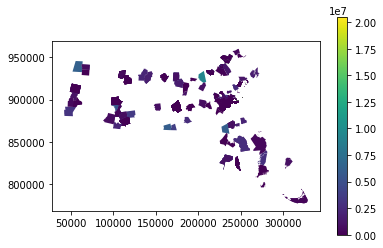

In [59]:
towns = gpd.read_file('townssurvey_shp/TOWNSSURVEY_POLY.shp')
# tax_credits['City/Town'] = tax_credits['City/Town'].str.upper()
# tax_credits = tax_credits.rename(columns={'City/Town': 'TOWN'})
htc_gdf = towns.merge(tax_credits, on = 'TOWN')
htc_gdf.plot('total_awards',legend=True)